In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from eofs.standard import Eof
import matplotlib.pyplot as plt
import IPython.display
import time
from scipy import signal

#### Define all functions we use later on

In [2]:
def trans_linear_to_2D(data, side_length = 9):
    """Transforms an array of the shape (timesteps, number_grid_p) into (timesteps, sqrt(number_grid_p),sqrt(number_grid_p))"""
    t_length, linear_length = data.shape
    assert linear_length == side_length**2
    
    reshaped_data = np.reshape(data,(t_length,side_length,side_length), order = 'F')
    return reshaped_data

def trans_2D_into_linear(data):
    """Transforms an array of the shape (timesteps, sqrt(number_grid_p),sqrt(number_grid_p)) into (timesteps, number_grid_p)"""
    t_length, side_length, side_length_y= data.shape
    assert side_length == side_length_y
    reshaped_data = np.reshape(data,(t_length,side_length**2),order = 'F')
    
    return reshaped_data
    

In [3]:
def reconstruct(eofs, pcs):
    """Function that reconstructs Fields from EOF and PC"""
    time_length, spatial_length = pcs.shape
    reconstructed_field = np.zeros(pcs.shape)
    
    for i in range(time_length):
        reconstructed_field[i,:] = np.sum(eofs*pcs[i,:,None], axis =0)
    return reconstructed_field

In [4]:
def get_eofs(eof_rawdata):
    """Do EOF analysis and give out Eof, PC and corresponding variance"""
    solver = Eof(eof_rawdata,weights=None)
    eofs = solver.eofs()
    variance_fraction = solver.varianceFraction()
    pcs = solver.pcs()
    pseudo_pcs = solver.projectField(eof_rawdata)
    return eofs, pseudo_pcs, variance_fraction


In [6]:
def pc_poly_extrapolation(pcs, polydegree, extratime):
    """Polynomial extrapolation of pcs function"""
    datapoints_for_fit = pcs.shape[0]
    pcs_new = np.transpose(pcs)
    times = np.arange(datapoints_for_fit)
    newtimes = np.arange(datapoints_for_fit + extratime)
    pcs_extra = []
    # polyft for pcs
    for i, pc in enumerate(pcs_new):
        coefficients = np.polyfit(times, pc, polydegree)
        pc_fitted = np.polyval(coefficients, newtimes)
        pcs_extra.append(pc_fitted)
    # transform extrapolated pcs into original shape
    pcs_extra = np.array(np.transpose(pcs_extra))
    return pcs_extra

#### Read data

In [7]:
v_x_pandas=pd.read_csv('velocity_x.csv')
v_y_pandas=pd.read_csv('velocity_y.csv')

In [8]:
v_x=v_x_pandas.values[:,1:]
v_y=v_y_pandas.values[:,1:]

In [10]:
v_x_2D = trans_linear_to_2D(v_x)
v_y_2D = trans_linear_to_2D(v_y)

#### Plot video of velocity field time development

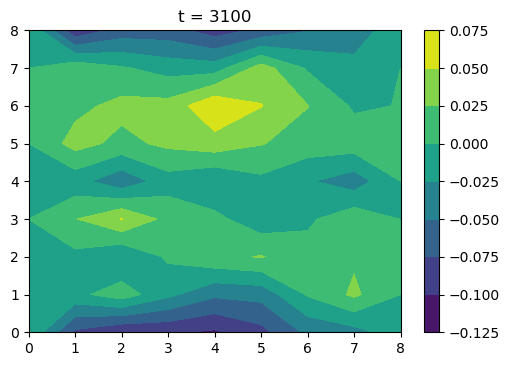

In [11]:
tstart = 3000
tstop = 3100
tstep = 50
var = v_y_2D
# defines field and time vector
trange = slice(tstart, tstop + 1, tstep)
tsteps = np.arange(tstart, tstop + 1, tstep)
field=var[trange, :, :]
# first plot
vmax = np.nanmax(field)
vmin = np.nanmin(field)
levels = np.linspace(vmin, vmax, 256)
fig, ax = plt.subplots(dpi=100)
cs = ax.contourf(field[0])
cbar = plt.colorbar(cs)
# display video
for i, f in enumerate(field):
    ax.collections = []
    cs = ax.contourf(f)
    plt.title("t = %s" % (tsteps[i]))    
    IPython.display.display(fig)
    IPython.display.clear_output(wait=True)
    time.sleep(0.5)

**U and V Seperated analysed in 1D**

In [12]:
eofs_x, pcs_x, variance_x = get_eofs(v_x)
eofs_y, pcs_y, variance_y = get_eofs(v_y)

**2D Analysis**, is not necessary, we demonstrate, that it does not matter if we do it in 2D or 1D

In [13]:
eofs_x_2D, pcs_x_2D, variance_x_2D = get_eofs(v_x_2D)

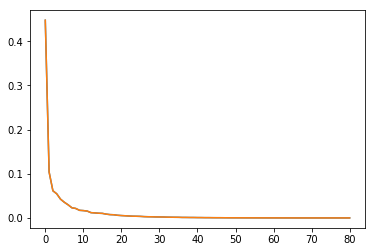

In [14]:
plt.plot(variance_x_2D)
plt.plot(variance_x)

In [15]:
trans_eofs_x_2D = trans_2D_into_linear(eofs_x_2D)

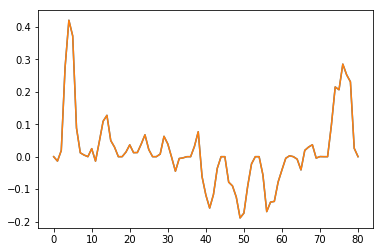

In [16]:
plt.plot(eofs_x[0,:])
plt.plot(trans_eofs_x_2D[0,:])

**Test**, Can perfectly reconstruct field, and EoFs are orthogonal

In [17]:
reconstructed_field_fun = reconstruct(eofs_x, pcs_x)
t_step = 100

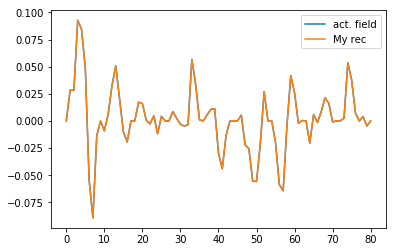

In [18]:
plt.plot(v_x[t_step,:],label = "act. field")
plt.plot(reconstructed_field_fun[t_step,:], label = "My rec")
plt.legend()

In [19]:
#Test of Orthogonality
for j in range(81):
    for i in range(81):
        diag_sum = np.sum(eofs_x[j,:]*eofs_x[i,:])
        if diag_sum>1e-14:
            print(diag_sum, i, j)

0.9999999999999993 0 0
1.0000000000000004 1 1
0.9999999999999996 2 2
1.0 3 3
1.0 4 4
1.0000000000000002 5 5
0.9999999999999999 6 6
1.0000000000000004 7 7
0.9999999999999991 8 8
1.0000000000000004 9 9
0.9999999999999996 10 10
0.9999999999999996 11 11
0.9999999999999992 12 12
0.9999999999999998 13 13
0.9999999999999994 14 14
0.9999999999999993 15 15
0.9999999999999998 16 16
1.0 17 17
0.9999999999999996 18 18
0.9999999999999998 19 19
1.0 20 20
1.0 21 21
1.0 22 22
0.9999999999999993 23 23
0.9999999999999999 24 24
1.0 25 25
0.9999999999999999 26 26
0.9999999999999999 27 27
1.0000000000000007 28 28
1.0000000000000004 29 29
0.9999999999999999 30 30
1.0 31 31
0.9999999999999992 32 32
1.0000000000000004 33 33
1.0000000000000002 34 34
1.0000000000000002 35 35
0.9999999999999997 36 36
1.0 37 37
1.0000000000000016 38 38
1.0000000000000004 39 39
1.0 40 40
1.0 41 41
0.9999999999999999 42 42
0.9999999999999998 43 43
0.9999999999999996 44 44
1.0 45 45
1.0000000000000009 46 46
0.9999999999999997 47 47


#### Polyfit extrapolation of weights of pcs

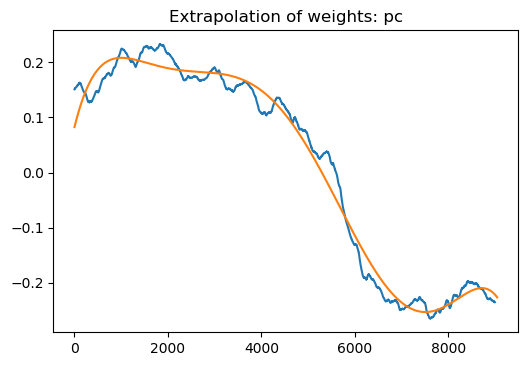

In [20]:
datapoints_for_fit = 9000
pcs_for_fit = slice(0, 1)
polydegree = 6
extratime = 50

pcs = pcs_x[-datapoints_for_fit:, pcs_for_fit]
pcs_x_extra = pc_poly_extrapolation(pcs, polydegree, extratime)
times = np.arange(pcs.shape[0])
newtimes = np.arange(pcs_x_extra.shape[0])
for pc, pc_extra in zip(np.transpose(pcs), np.transpose(pcs_x_extra)):
    fig = plt.figure(dpi=100)
    plt.plot(times, pc)
    plt.plot(newtimes, pc_extra)
    plt.title("Extrapolation of weights: pc")